{'000100': 13, '100011': 22, '000110': 20, '111111': 10, '111011': 13, '110100': 7, '110000': 16, '011010': 11, '010010': 18, '001101': 22, '110110': 20, '001011': 20, '011011': 12, '001001': 14, '111100': 10, '001000': 17, '111010': 20, '000000': 19, '110001': 16, '000101': 16, '011101': 15, '010110': 11, '010001': 16, '010111': 14, '111101': 12, '100010': 17, '011000': 15, '101000': 12, '001100': 18, '101111': 19, '011100': 18, '010100': 14, '000111': 16, '001010': 19, '000001': 21, '100101': 12, '110011': 13, '101101': 18, '100110': 20, '010000': 19, '111001': 15, '100001': 11, '110111': 16, '011001': 12, '101011': 21, '110010': 19, '001111': 24, '110101': 15, '111000': 21, '000010': 17, '100000': 12, '111110': 19, '011111': 26, '101001': 11, '000011': 13, '100111': 9, '101100': 11, '100100': 16, '011110': 18, '010101': 18, '010011': 17, '001110': 17, '101010': 12, '101110': 19}
Total shots = 1024


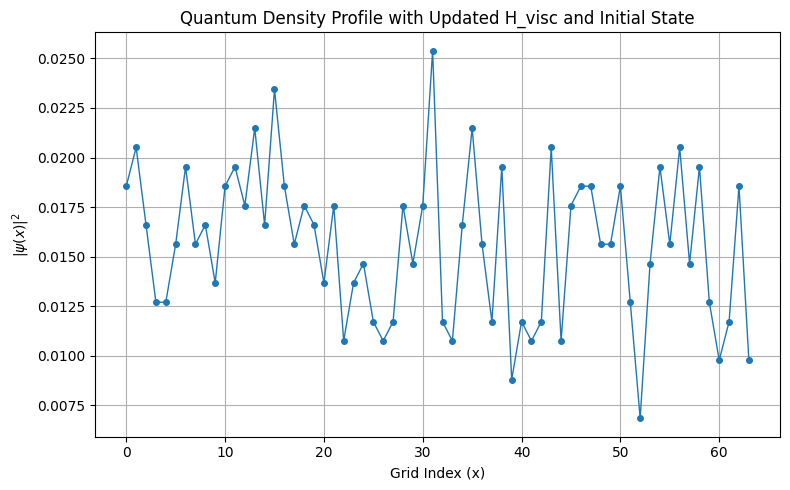

In [9]:
import numpy as np
from math import ceil, log2
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import QFT
from qiskit_aer import QasmSimulator
try:
    from qiskit.circuit.library import DiagonalGate
except ImportError:
    from qiskit.circuit.library.generalized_gates import DiagonalGate
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt # Import matplotlib for custom plotting

# 1. Constants
N       = 64 # Number of discrete position states
n_q     = ceil(log2(N)) # Number of qubits required to represent N states
t_tot   = 1.0 # Total simulation time
r       = 100 # Number of Trotter steps (Trotterization depth)
dt      = t_tot / r # Time step for each Trotter slice
hbar    = 1.0 # Planck's constant (set to 1 as per problem note)


delta_0 = 1.0   # "δ0 = 1"
epsilon_0 = 0.1 # can be adjusted


x_vals  = np.linspace(0, 1, N, endpoint=False) # x_vals represent the discrete positions from 0 to 1 (exclusive of 1)

# H_viscous = -hbar^2 / (2*delta_0^2) * [
#   epsilon_0^4 * pi^2 * sin^2(pi*x) * cos^2(pi*x) +
#   (epsilon_0 * cos(x) * sin(pi*x) - epsilon_0 * pi * sin(x) * cos(pi*x))^2 +
#   (epsilon_0 * sin(x) * sin(pi*x) + epsilon_0 * pi * cos(x) * cos(pi*x))^2
# ]

H_visc_array = np.zeros(N)
for i, x_val in enumerate(x_vals):
    # Term 1
    term1_H_visc = (epsilon_0**4 * np.pi**2 * (np.sin(np.pi * x_val))**2 * (np.cos(np.pi * x_val))**2)
    
    # Term 2
    base_term2_H_visc = (epsilon_0 * np.cos(x_val) * np.sin(np.pi * x_val) -
                         epsilon_0 * np.pi * np.sin(x_val) * np.cos(np.pi * x_val))
    term2_H_visc = base_term2_H_visc**2
    
    # Term 3
    base_term3_H_visc = (epsilon_0 * np.sin(x_val) * np.sin(np.pi * x_val) +
                         epsilon_0 * np.pi * np.cos(x_val) * np.cos(np.pi * x_val))
    term3_H_visc = base_term3_H_visc**2
    
    # Combined Terms
    H_visc_array[i] = - (hbar**2 / (2 * delta_0**2)) * (term1_H_visc + term2_H_visc + term3_H_visc)

# 3. Build QFT & inverse-QFT circuits
qft     = QFT(n_q, do_swaps=True).decompose()
inv_qft = qft.inverse() # Inverse QFT to switch back

def add_kinetic_step(qc: QuantumCircuit):

    qc.append(qft, range(n_q)) # Apply QFT to move to momentum basis
    
    # Calculate the complex phases for each computational basis state |k> (momentum state)
    kinetic_phases = []
    for k in range(2**n_q): # k iterates through all possible integer values represented by n_q qubits
        # The kinetic energy is proportional to k^2 in momentum space
        phi_k = (hbar**2 * k**2 / 2) * dt
        kinetic_phases.append(np.exp(-1j * phi_k)) # Calculate e^(-i * phi_k)
    
    # Apply the diagonal gate using DiagonalGate 
    qc.append(DiagonalGate(kinetic_phases), range(n_q))
    
    qc.append(inv_qft, range(n_q)) # Apply inverse QFT to move back to position basis

def add_H_visc_step(qc: QuantumCircuit):

    H_visc_phases = []
    for x_idx in range(N):
        # The H_visc energy is directly H_visc_array[x_idx]
        # The angle for time evolution is H_visc(x) * dt
        angle_H_visc = H_visc_array[x_idx] * dt
        H_visc_phases.append(np.exp(-1j * angle_H_visc))
    
    # Apply the diagonal gate using DiagonalGate 
    qc.append(DiagonalGate(H_visc_phases), range(n_q))


# 4. Build the main Trotter circuit
# Initialize a quantum circuit with n_q qubits and n_q classical bits for measurement
qc = QuantumCircuit(n_q, n_q)


epsilon_0_initial = 0.01 # Renamed to avoid clash with H_visc epsilon_0

initial_state_amplitudes = np.zeros(N, dtype=complex)

for i in range(N):
    x_val = x_vals[i] # Get the continuous x value for this grid point

    if x_val <= 0.5:
        # Ψ(x, 0) = cos(x) + i sin(x) + j ε0 sin(πx)
        # Interpreting cos(x) + i sin(x) as e^(ix)
        term1 = np.exp(1j * x_val)
        term2 = 1j * epsilon_0_initial * np.sin(np.pi * x_val)
        initial_state_amplitudes[i] = term1 + term2
    else: # x_val > 0.5
        # Ψ(x, 0) = cos(0.5) + i sin(0.5) + j ε0 sin(0.5)
        # Interpreting cos(0.5) + i sin(0.5) as e^(i*0.5)
        constant_part = np.exp(1j * 0.5)
        term2_gt_0_5 = 1j * epsilon_0_initial * np.sin(0.5) # sin(0.5) is a constant here
        initial_state_amplitudes[i] = constant_part + term2_gt_0_5

# Normalize the initial state vector
norm = np.linalg.norm(initial_state_amplitudes)
if norm != 0:
    initial_state_amplitudes = initial_state_amplitudes / norm
else:
    print("Warning: Initial state amplitudes sum to zero. State will be all zeros.")

# Apply the initial state to the quantum circuit
qc.initialize(initial_state_amplitudes, range(n_q))



# 4.2 Time evolution using Trotter steps
# This implements the first-order Trotter-Suzuki decomposition for H = H_kinetic + H_visc(x)
for _ in range(r):
    add_kinetic_step(qc)   # Apply kinetic energy evolution
    add_H_visc_step(qc)    # Apply the H_visc(x) term evolution

qc.barrier() # Optional: Adds a visual barrier in the circuit diagram for clarity
qc.measure(range(n_q), range(n_q)) # Measure all quantum bits and store results in classical bits

# 5. Run on QasmSimulator
backend     = QasmSimulator()
qc_compiled = transpile(qc, backend) 
job         = backend.run(qc_compiled, shots=1024) 
result      = job.result() 
counts      = result.get_counts() 

# 6. Plot |ψ(x)|²
print(counts)
total_shots = sum(counts.values())
print(f"Total shots = {total_shots}")

# Build a list of (x, P(x)) pairs
probs = []
for bitstr, cnt in counts.items():
    x = int(bitstr, 2)      # convert '0101' → 5 (grid index)
    p = cnt / total_shots   # probability estimate
    probs.append((x, p))

# Sort by x (grid index) to ensure correct plotting order
probs.sort(key=lambda pair: pair[0])

xs, ps = zip(*probs)   

plt.figure(figsize=(8,5))
plt.plot(xs, ps, marker='o', linestyle='-', markersize=4, linewidth=1)
plt.xlabel('Grid Index (x)')
plt.ylabel(r'$|\psi(x)|^2$')
plt.title('Quantum Density Profile with Updated H_visc and Initial State')
plt.grid(True)
plt.tight_layout()
plt.show()


In [5]:
print(f"Sum of probabilities (ps): {np.sum(ps)}") # normalization is correct

Sum of probabilities (ps): 1.0
